In [28]:
import torch
print(torch.cuda.is_available())

True


In [29]:
# %env CUDA_VISIBLE_DEVICES=2
import sys
# sys.path.append('/home/a_razumov/projects/k-space-mri')
import numpy as np
import pylab as plt
import pickle
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F

import sys
print(sys.path)
sys.path.append('/home/avishka/biyon/Undersamping_MRI/CPU_code/IGS' )
# sys.path.remove('/home/avishka/biyon/Undersamping_MRI/CPU_code/IGS')
# print(sys.path)

from k_space_reconstruction.utils.metrics import pt_msssim, pt_ssim
from k_space_reconstruction.datasets.acdc import ACDCSet, ACDCTransform, RandomMaskFunc
from k_space_reconstruction.datasets.fastmri import FastMRIh5Dataset, FastMRITransform, LegacyFastMRIh5Dataset
from k_space_reconstruction.utils.kspace import EquispacedMaskFunc, RandomMaskFunc
from k_space_reconstruction.utils.kspace import pt_spatial2kspace as Ft
from k_space_reconstruction.utils.kspace import pt_kspace2spatial as IFt

import os
from k_space_reconstruction.nets.unet import Unet
from k_space_reconstruction.nets.enet import ENet
from k_space_reconstruction.nets.mwcnn import MWCNN
import datetime
import torch
import torchvision
import numpy as np
import pylab as plt
plt.style.use('bmh')
import albumentations
import numpy as np
import h5py
import pylab as plt
import torch
import torch.nn.functional as F

import os
import re
import numpy as np
import pandas as pd
import nibabel

import torch
import torch.utils.data
import torchvision.transforms as transforms
from torch.optim import Adam

from os.path import isdir, join
from typing import Callable, Dict, List, Any

['/home/avishka/biyon/Undersamping_MRI/Cuda_code/IGS/notebooks/acdc', '/home/avishka/anaconda3/envs/wm/lib/python310.zip', '/home/avishka/anaconda3/envs/wm/lib/python3.10', '/home/avishka/anaconda3/envs/wm/lib/python3.10/lib-dynload', '', '/home/avishka/anaconda3/envs/wm/lib/python3.10/site-packages', '/home/avishka/biyon/Undersamping_MRI/CPU_code/IGS', '/home/avishka/biyon/Undersamping_MRI/CPU_code/IGS']


In [30]:
print(torch.cuda.is_available())
device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')
print(device)

True
cuda:1


In [2]:
fig_bezzeless = lambda nc, nr : plt.subplots(ncols=nc, nrows=nr, figsize=(4 * nc, 4), dpi=120, 
                                             subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                                             gridspec_kw=dict(wspace=0.0, hspace=0.0))


def ce_loss(true, logits, weights, ignore=255):
    torch.nn.CrossEntropyLoss
    ce_loss = torch.nn.functional.cross_entropy(
        logits.float(),
        true.long(),
        ignore_index=ignore,
        weight=weights,
    )
    return ce_loss


def dice_loss(true, logits, eps=1e-7):
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes, device=true.device)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = torch.nn.functional.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

def dice_coeffs(true, logits):
    num_classes = logits.shape[1]
    probas = F.softmax(logits, dim=1)
    probas[probas > 0.5] = 1; probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(true).float()
    for i in range(1, num_classes):
        pmask[:,0] += i * probas[:,i]
    dice_ls = []
    for i in range(1, num_classes):
        yt = (true==i).float().flatten()
        yp = (pmask==i).float().flatten()
        intersection = torch.sum(yt * yp)
        cardinality = torch.sum(yt + yp)
        dice_ls.append((2. * intersection / (cardinality + 1e-7)).item())
    return dice_ls        

def train_sampling_pattern(train_generator, model, n=14):
    criterion = lambda p,t : dice_loss(t, p) * .75 + ce_loss(t.squeeze(1), p, weights=None) * .25
    c, bmasks, images, bmean, bstd = next(iter(train_generator))
    bks = Ft(images * bstd + bmean)
    bgt = IFt(bks).abs()
    w = torch.zeros(256, 256).to(device).float()
    w[:,128] = 1
    bbatch = 32
    w_list = []
    pbar = tqdm(range(n))
    for count in pbar:
        w = torch.autograd.Variable(w, requires_grad=True)
        for j in range(bks.shape[0] // bbatch):
            bbks = bks[bbatch*j:bbatch*(j+1)].to(device)
            bbgt = bgt[bbatch*j:bbatch*(j+1)].to(device)
            bbmean = bmean[bbatch*j:bbatch*(j+1)].to(device)
            bbstd = bstd[bbatch*j:bbatch*(j+1)].to(device)
            bbmasks = bmasks[bbatch*j:bbatch*(j+1)].to(device)
            bbmasks = bbmasks.long().to(device)
            recs = IFt(bbks * w).abs()
            recs = recs.to(device)
            inp = (recs - bbmean) / (bbstd + 1e-11)
            # print(inp.is_cuda)
            inp = inp.to(device)
            pm = model(inp)
            # print(pm.is_cuda)
            # print(bbmasks.is_cuda)
            loss = criterion(pm, bbmasks)
            loss.backward()
        
        # print(w.grad)
        for i in torch.topk(w.grad.flatten(), 256*256, largest=False).indices:
            if w.flatten()[i] == 0: 
                w = w.detach().flatten()
                w[i] = 1.
                w = w.unflatten(0, (256,256))
                w_list.append(w.clone().cpu())
                pbar.set_description('select: %d, loss: %.6f' % (i.item(), loss.item()))
                break
    return w_list

def test_sampling_pattern(sampling, model, val_generator):
    vc, vbmasks, vimages, vbmean, vbstd = next(iter(val_generator))
    vbks = Ft(vimages * vbstd + vbmean)
    vbgt = IFt(vbks).abs()
    dice_scores = []
    bbatch = 1
    for j in tqdm(range(vbks.shape[0] // bbatch)):
        vbbks = vbks[bbatch*j:bbatch*(j+1)].to(device)
        vbbgt = vbgt[bbatch*j:bbatch*(j+1)].to(device)
        vbbmean = vbmean[bbatch*j:bbatch*(j+1)].to(device)
        vbbstd = vbstd[bbatch*j:bbatch*(j+1)].to(device)
        vbbmasks = vbmasks[bbatch*j:bbatch*(j+1)].to(device)
        with torch.no_grad():
            # igs
            sampling = sampling.to(device)
            recs = IFt(vbbks * sampling).abs()
            pm = model((recs - vbbmean) / (vbbstd + 1e-11))
            for i in range(recs.shape[0]):
                dice_scores.append(1 - dice_loss(vbbmasks.long(), pm).item())
    return dice_scores

def test_on_classes_sampling_pattern(sampling, model, val_generator):
    vc, vbmasks, vimages, vbmean, vbstd = next(iter(val_generator))
    vbks = Ft(vimages * vbstd + vbmean)
    vbgt = IFt(vbks).abs()
    dice_scores = []
    bbatch = 1
    for j in tqdm(range(vbks.shape[0] // bbatch)):
        vbbks = vbks[bbatch*j:bbatch*(j+1)].to(device)
        vbbgt = vbgt[bbatch*j:bbatch*(j+1)].to(device)
        vbbmean = vbmean[bbatch*j:bbatch*(j+1)].to(device)
        vbbstd = vbstd[bbatch*j:bbatch*(j+1)].to(device)
        vbbmasks = vbmasks[bbatch*j:bbatch*(j+1)].to(device)
        with torch.no_grad():
            # igs
            sampling = sampling.to(device)
            recs = IFt(vbbks * sampling).abs()
            pm = model((recs - vbbmean) / (vbbstd + 1e-11))
            print(recs.shape)
            for i in range(recs.shape[0]):
                dice_scores.append(dice_coeffs(vbbmasks.long(), pm))
    return dice_scores

class ACDCDataset(torch.utils.data.Dataset):
    CLASSES = {0: 'NOR', 1: 'MINF', 2: 'DCM', 3: 'HCM', 4: 'RV'}

    def __init__(self, hf_path: str):
        super().__init__()
        self.hf = h5py.File(hf_path)

    def __len__(self) -> int:
        return len(self.hf)

    def __getitem__(self, item: int):
        # img = self.hf[str(item)][:1]
        img = self.hf[str(item)].get('img')
        mask = self.hf[str(item)].get('gt')
        c = self.hf[str(item)].attrs['class']
        img = torch.tensor(img).float()
        mask = torch.tensor(mask)
        mean = img.mean().unsqueeze(0).unsqueeze(0).unsqueeze(0)
        std = img.std().unsqueeze(0).unsqueeze(0).unsqueeze(0)
        img = (img - mean) / (std + 1e-11)

        # print('mean', mean.shape)
        # print('std', std.shape)
        return c, mask.unsqueeze(0), img, mean, std

NameError: name 'torch' is not defined

In [32]:
def pt_psnr(img1, img2, maxval):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(maxval / torch.sqrt(mse))

In [33]:
# np.random.seed(42)
# torch.manual_seed(42)
# train_dataset = ACDCDataset('/home/avishka/biyon/Dataset/Small/train25.h5')
# val_dataset = ACDCDataset('/home/avishka/biyon/Dataset/Small/val10.h5')
# c,mask,img,mean,std = train_dataset[10]
# print(img.shape)
# print(mask.shape)
# print(mean)
# print(std)
# print(len(val_dataset))

# train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True, num_workers=6)
# val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
# train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=6)
# val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

np.random.seed(42)
torch.manual_seed(42)
train_dataset = ACDCDataset('/home/avishka/biyon/Dataset/Medium/train100.h5')
val_dataset = ACDCDataset('/home/avishka/biyon/Dataset/Medium/val50.h5')
c,mask,img,mean,std = train_dataset[10]
print(img.shape)
print(mask.shape)
print(mean)
print(std)
print(len(val_dataset))

train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True, num_workers=6)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

# train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
# val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

# train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=6)
# val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=False)

torch.Size([1, 256, 256])
torch.Size([1, 256, 256])
tensor([[[83.9895]]])
tensor([[[86.1291]]])
54


In [34]:

model = Unet(1, 3+1).to(device).train(False).eval()
# for p in model.parameters():
#     p.requires_grad = False
# model.load_state_dict(torch.load('unet-acdc-norot.pt'))
# print(model.is_cuda)

# 5-fold validation x16

In [35]:
from collections import defaultdict
from sklearn.model_selection import KFold

fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [16])((256, 256))[0]).float()
zm = torch.zeros(256,256).float()
zm[256//2 - int(16)//2 : 256//2 + int(16)//2, 256//2 - int(16)//2 : 256//2 + int(16)//2] = 1
fm = torch.ones(256).float()

dice_fold_scores = defaultdict(dict)

In [36]:


for i, (train_id, val_id) in enumerate(KFold(shuffle=False).split(range(len(train_dataset)))):
    print('Fold: ',i)
    td = torch.utils.data.Subset(train_dataset, train_id)
    vd = torch.utils.data.Subset(train_dataset, val_id)
    print(len(td),len(vd))
    # break
    tg = torch.utils.data.DataLoader(td, batch_size=len(td), shuffle=True)
    vg = torch.utils.data.DataLoader(vd, batch_size=len(vd), shuffle=False)
    # tg = torch.utils.data.DataLoader(td, batch_size=2, shuffle=True)
    # vg = torch.utils.data.DataLoader(vd, batch_size=2, shuffle=False)
    print(len(tg),len(vg))
    # break
    w_list = train_sampling_pattern(tg, model, n=16)
    dice_fold_scores[i] = dict(
        ours=test_sampling_pattern(w_list[14], model, vg),
        fastmri=test_sampling_pattern(fastmri_mask_x16, model, vg), 
        center=test_sampling_pattern(zm, model, vg),
    )
    
fold_scores = [{k:[vv for vv in v] for k,v in dv.items()} for dv in dice_fold_scores.values()]
with open('unet_fold_scores_unetTrain.pkl', mode='wb') as f: pickle.dump(fold_scores, f)

Fold:  0
97 25
1 1


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Fold:  1
97 25
1 1


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Fold:  2
98 24
1 1


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Fold:  3
98 24
1 1


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

Fold:  4
98 24
1 1


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [37]:
with open('unet_fold_scores_unetTrain.pkl', 'rb') as f: fold_scores = pickle.load(f)

In [38]:
import scipy

df_dice = pd.DataFrame.from_dict({
    'fastmri': [np.mean(v['fastmri']) for v in fold_scores],
    'center': [np.mean(v['center']) for v in fold_scores],
    'ours': [np.mean(v['ours']) for v in fold_scores]
})
print(scipy.stats.ttest_rel(df_dice.center, df_dice.ours))
df_dice.describe()

Ttest_relResult(statistic=-8.944649497926198, pvalue=0.0008640709129651226)


,fastmri,center,ours
count,5.000000,5.000000,5.000000
mean,0.138074,0.137602,0.139892
std,0.002796,0.002509,0.003048
min,0.134889,0.134733,0.136423
25%,0.135603,0.135227,0.137138
50%,0.138912,0.138485,0.140743
75%,0.139313,0.139074,0.141481
max,0.141651,0.140492,0.143672


# Training on full train

In [41]:
w_list = train_sampling_pattern(train_generator, model, n=5000)
torch.save(w_list, 'sampling_2d_igs_unetTrain.pt')
torch.save(model.state_dict(),'unet-acdc.pt')

  0%|          | 0/5000 [00:00<?, ?it/s]

In [42]:
w_list[-1].sum()

tensor(5256.)

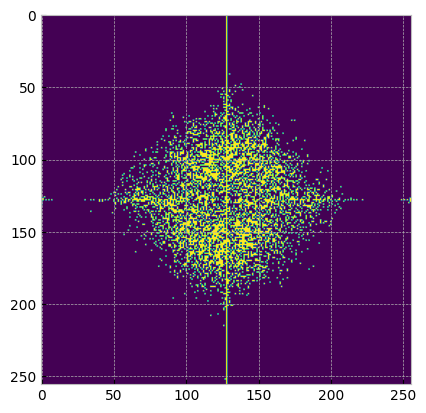

In [43]:
plt.imshow(w_list[-1])

In [44]:
w = torch.load('sampling_2d_igs_unetTrain.pt')[-1]

fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [float(256*256 / w.sum())])((256, 256))[0]).cuda().float()
zm = torch.zeros(256).cuda().float()
zm[256//2 - int(256 / (256*256 / w.sum()))//2 : 256//2 + int(256 / (256*256 / w.sum()))//2] = 1
zm2 = torch.zeros(256, 256).cuda().float()
zm2[256//2 - int(w.sum()**0.5+1)//2:256//2 + int(w.sum()**0.5+1)//2, 256//2 - int(w.sum()**0.5+1)//2:256//2 + int(w.sum()**0.5+1)//2] = 1
fm = torch.ones(256).cuda().float()

In [45]:
fastmri_mask_x16.sum(), zm.sum(), zm2.sum(), w.sum()

(tensor(20., device='cuda:0'),
 tensor(20., device='cuda:0'),
 tensor(5184., device='cuda:0'),
 tensor(5256.))

In [46]:
dice_scores = dict(
    fastmri=test_sampling_pattern(fastmri_mask_x16, model, val_generator), 
    center=test_sampling_pattern(zm, model, val_generator),
    center2d=test_sampling_pattern(zm2, model, val_generator),
    ours=test_sampling_pattern(w.cuda(), model, val_generator),
)

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

In [47]:
df_dice = pd.DataFrame.from_dict(dice_scores)
df_dice.describe()

,fastmri,center,center2d,ours
count,54.000000,54.000000,54.000000,54.000000
mean,0.132478,0.132134,0.132155,0.132957
std,0.005994,0.005862,0.005978,0.005949
min,0.120621,0.120623,0.120278,0.121018
25%,0.128390,0.127934,0.127850,0.128905
50%,0.133291,0.133056,0.133239,0.134183
75%,0.136723,0.136194,0.136401,0.137096
max,0.142939,0.142161,0.142464,0.142097


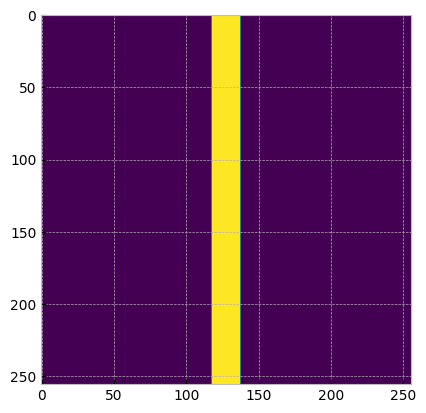

In [51]:
plt.imshow(np.broadcast_to(zm.cpu(),(256,256)))

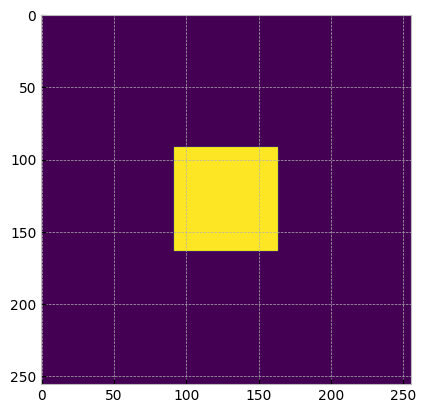

In [52]:
plt.imshow(zm2.cpu())

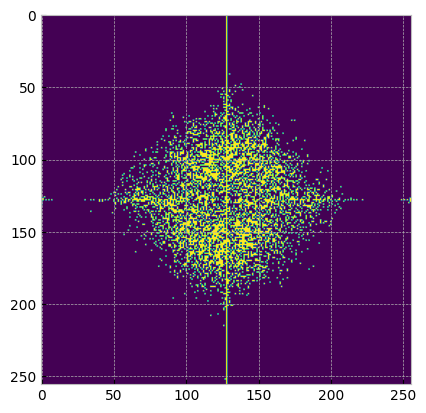

In [49]:
plt.imshow(w.cpu())

# Eval dice classes scores

In [26]:
fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [8])((256, 256))[0]).cuda().float()
zm = torch.zeros(256).cuda().float()
zm[256//2 - int(32)//2 : 256//2 + int(32)//2] = 1
fm = torch.ones(256).cuda().float()
w = torch.load('sampling_igs.pt')[30]

FileNotFoundError: [Errno 2] No such file or directory: 'sampling_igs.pt'

In [ ]:
dice_class_scores = dict(
    fastmri=test_on_classes_sampling_pattern(fastmri_mask_x16, model, val_generator), 
    center=test_on_classes_sampling_pattern(zm, model, val_generator),
    ours=test_on_classes_sampling_pattern(w, model, val_generator),
    full=test_on_classes_sampling_pattern(fm, model, val_generator),
)

In [ ]:
class_map = {0: 'RV cavity', 1: 'LV myo', 2: 'LV cavity'}
for name in dice_class_scores.keys():
    arr = np.array(dice_class_scores[name]).T
    print('##############', name, '##############')
    print(pd.DataFrame.from_dict({class_map[i]:arr[i] for i in range(arr.shape[0])}).describe())

In [ ]:
fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [16])((256, 256))[0]).cuda().float()
zm = torch.zeros(256).cuda().float()
zm[256//2 - int(16)//2 : 256//2 + int(16)//2] = 1
fm = torch.ones(256).cuda().float()
w = torch.load('sampling_igs.pt')[14]

dice_class_scores = dict(
    fastmri=test_on_classes_sampling_pattern(fastmri_mask_x16, model, val_generator), 
    center=test_on_classes_sampling_pattern(zm, model, val_generator),
    ours=test_on_classes_sampling_pattern(w, model, val_generator),
    full=test_on_classes_sampling_pattern(fm, model, val_generator),
)

class_map = {0: 'RV cavity', 1: 'LV myo', 2: 'LV cavity'}
for name in dice_class_scores.keys():
    arr = np.array(dice_class_scores[name]).T
    print('##############', name, '##############')
    print(pd.DataFrame.from_dict({class_map[i]:arr[i] for i in range(arr.shape[0])}).describe())